# 1. Set Up

In [2]:
import math
import os
import re
import sys
import time
import json
from pathlib import Path
import subprocess
import zipfile
from pydantic import BaseModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyvista as pv
import gmsh

sys.path.append('/mofem_install/jupyter/thomas/mfront_example_test/src')

import setup
import core
import custom_models as cm
import utils as ut
import plotting
import calculations as calc
    
import matplotlib
matplotlib.rc('figure', figsize=(7, 7))

In [3]:
#in MPa
def initialize_parameters(custom_mesh_filepath: str = None, soil_model: cm.PropertyTypeEnum = cm.PropertyTypeEnum.le, **kwargs) -> cm.AttrDict:
    params = cm.AttrDict()
    setattr(params, "custom_mesh_filepath", custom_mesh_filepath)
    setattr(params, "soil_model", soil_model)
    for key,value in kwargs.items():
        setattr(params, key, value)
    params.interface = False
    params.pile_manager = cm.PileManager(x=0, y=0, z=0, dx=0, dy=0, R=1, r=0.975,
                                         stickup_height = 10,
                                         embedded_depth = -10.5,
                                preferred_model= cm.PropertyTypeEnum.le,
                                props = {
                                    cm.PropertyTypeEnum.le: cm.ElasticProperties(youngs_modulus=200000, poisson_ratio=0.3),
                                },
                                interface = params.interface,
                                )

    soil_layer_1 = cm.SoilLayer(
        depth = -2,
        preferred_model= params.soil_model,
        props = {
            cm.PropertyTypeEnum.le: cm.ElasticProperties(youngs_modulus=96, poisson_ratio=0.49),
            cm.PropertyTypeEnum.vM: cm.VonMisesProperties(youngs_modulus=96, poisson_ratio=0.49, HardeningSlope = 0, YieldStress = 10),
            cm.PropertyTypeEnum.dp: cm.DruckerPragerProperties(youngs_modulus=96, poisson_ratio=0.3, phi=np.radians(15), c=10, v=np.radians(15)),
            cm.PropertyTypeEnum.mcc: cm.CamClayProperties(),
            }, 
            )
    soil_layer_2 = cm.SoilLayer(
        depth = -1.4,
        preferred_model= params.soil_model,
        props = {
            cm.PropertyTypeEnum.le: cm.ElasticProperties(youngs_modulus=182.1, poisson_ratio=0.49),
            cm.PropertyTypeEnum.vM: cm.VonMisesProperties(youngs_modulus=182.1, poisson_ratio=0.49, HardeningSlope = 0, YieldStress = 10),
            cm.PropertyTypeEnum.dp: cm.DruckerPragerProperties(youngs_modulus=182.1, poisson_ratio=0.3, phi=np.radians(15), c=10, v=np.radians(15)),
            cm.PropertyTypeEnum.mcc: cm.CamClayProperties(),
            }, 
            )
    soil_layer_3 = cm.SoilLayer(
        depth = -7.1,
        preferred_model= params.soil_model,
        props = {
            cm.PropertyTypeEnum.le: cm.ElasticProperties(youngs_modulus=351.3, poisson_ratio=0.49),
            cm.PropertyTypeEnum.vM: cm.VonMisesProperties(youngs_modulus=351.3, poisson_ratio=0.49, HardeningSlope = 0, YieldStress = 10),
            cm.PropertyTypeEnum.dp: cm.DruckerPragerProperties(youngs_modulus=351.3, poisson_ratio=0.3, phi=np.radians(15), c=10, v=np.radians(15)),
            cm.PropertyTypeEnum.mcc: cm.CamClayProperties(),
                 }, 
            )
    soil_layer_4 = cm.SoilLayer(
        depth = -29.5,
        preferred_model= params.soil_model,
        props = {
            cm.PropertyTypeEnum.le: cm.ElasticProperties(youngs_modulus=668.4, poisson_ratio=0.49),
            cm.PropertyTypeEnum.vM: cm.VonMisesProperties(youngs_modulus=668.4, poisson_ratio=0.49, HardeningSlope = 0, YieldStress = 10),
            cm.PropertyTypeEnum.dp: cm.DruckerPragerProperties(youngs_modulus=668.4, poisson_ratio=0.3, phi=np.radians(15), c=10, v=np.radians(15)),
            cm.PropertyTypeEnum.mcc: cm.CamClayProperties(),
            }, 
            )
    
    # params.interface_manager = cm.InterfaceManager(
    #     preferred_model = cm.PropertyTypeEnum.vM,
    #     props = {
    #         cm.PropertyTypeEnum.le: cm.ElasticProperties(youngs_modulus=96, poisson_ratio=0.3),
    #         cm.PropertyTypeEnum.vM: cm.VonMisesProperties(youngs_modulus=96, poisson_ratio=0.49,HardeningSlope = 5000, YieldStress = 20),
    #         cm.PropertyTypeEnum.dp: cm.DruckerPragerProperties(youngs_modulus=668.4, poisson_ratio=0.49, phi=np.radians(0.05), c=0, v=np.radians(0.05)),
    #         },
    #         )
    
    #=======================================================
    #=======================================================
    #=======================================================
    #if the soil domain is a cuboid
    params.box_manager = cm.BoxManager(x=-80, y=-80, z=0, dx=160, dy=80,
        layers=[
        soil_layer_1,
        soil_layer_2,
        soil_layer_3,
        soil_layer_4,   
        ],
        far_field_size=5,
        near_field_dist=5,
        near_field_size=0.05,
    )
    #if the soil domain is a half cylinder
    params.cylinder_manager = cm.CylinderManager(
        x=0, 
        y=0, 
        z=0, 
        dx=0, 
        dy=0, 
        r=80,
        pile_R = params.pile_manager.R,
        pile_r = params.pile_manager.r,
        layers=[
        soil_layer_1,
        soil_layer_2,
        soil_layer_3,
        soil_layer_4,   
        ],
        mesh_radial_progression = 1.3,
        mesh_radial_divisions = 10,
    )
    #=======================================================
    #=======================================================
    #=======================================================
    
    def custom_generate_physical_groups(params) -> list[cm.PhysicalGroup]:
        physical_group_list = [
            cm.PhysicalGroup(
                meshnet_id=1,
                name="MFRONT_MAT_1",
                preferred_model=params.cylinder_manager.layers[0].preferred_model,
                props=params.cylinder_manager.layers[0].props,
                ),
            cm.PhysicalGroup(
                meshnet_id=2,
                name="MFRONT_MAT_2",
                preferred_model=params.cylinder_manager.layers[1].preferred_model,
                props=params.cylinder_manager.layers[1].props,
                ),
            cm.PhysicalGroup(
                meshnet_id=3,
                name="MFRONT_MAT_3",
                preferred_model=params.cylinder_manager.layers[2].preferred_model,
                props=params.cylinder_manager.layers[2].props,
                ),
            cm.PhysicalGroup(
                meshnet_id=4,
                name="MFRONT_MAT_4",
                preferred_model=params.cylinder_manager.layers[3].preferred_model,
                props=params.cylinder_manager.layers[3].props,
                ),
            cm.PhysicalGroup(
                meshnet_id=5,
                name="MFRONT_MAT_5",
                preferred_model=params.pile_manager.preferred_model,
                props=params.pile_manager.props,
                ),
        ]
        return physical_group_list
    
    if getattr(params, "custom_mesh_filepath", False):
        try:
            params.custom_generate_physical_groups = custom_generate_physical_groups
        except NameError as e:
            raise NameError("Must provided the custom callback 'custom_generate_physical_groups' to inject attributes to the main commmand.")
   
    params.nproc = 8 # number of processors/cores used
    params.dim = 3
    
    params.wk_dir = Path(f"/mofem_install/jupyter/thomas/mfront_example_test")
    params.read_med_exe = "/mofem_install/jupyter/thomas/um_view/bin/read_med"
    params.h5m_to_vtk_converter = "/mofem_install/jupyter/thomas/um_view/bin/convert.py"
    params.partition_exe = "/mofem_install/jupyter/thomas/um_view/bin/mofem_part"
    params.exe = f"/mofem_install/jupyter/thomas/um_view/tutorials/adv-1/contact_3d"
    params.paraview_path = "/mofem_install/jupyter/thomas/ParaView-5.13.1-MPI-Linux-Python3.10-x86_64/bin/pvpython"
    params.ffmpeg_path = '/mofem_install/jupyter/thomas/ffmpeg-7.0.2-amd64-static/ffmpeg'
    params.preset_dir = '/mofem_install/jupyter/thomas/mfront_example_test/src/presets'
    
    return params

In [7]:
points_of_interest = [
        cm.Point(x=1,y=0,z=10),
        cm.Point(x=-1,y=0,z=0),
        cm.Point(x=-1,y=0,z=-10.5),
    ]
line_of_interest = cm.Line(pt1=cm.Point(x=-1,y=0,z=10), pt2=cm.Point(x=-1,y=0,z=-40),)

In [ ]:
class InitParams(BaseModel):
    soil_model: cm.PropertyTypeEnum
    custom_mesh_filepath: str
    FEA_completed: bool
    days_since_epoch: int | None = None
    sim_otd: int | None = None
    base: str


# bulk_analysis_set = [
#     InitParams(soil_model=cm.PropertyTypeEnum.le, custom_mesh_filepath="/mofem_install/jupyter/thomas/mfront_example_test/user_data/pile_1.cub", base="hex", FEA_completed=False, days_since_epoch=None, sim_otd=None),
#     InitParams(soil_model=cm.PropertyTypeEnum.le, custom_mesh_filepath="/mofem_install/jupyter/thomas/mfront_example_test/user_data/pile_2.cub", base="hex", FEA_completed=False, days_since_epoch=None, sim_otd=None),
#     InitParams(soil_model=cm.PropertyTypeEnum.le, custom_mesh_filepath="/mofem_install/jupyter/thomas/mfront_example_test/user_data/pile_3.cub", base="hex", FEA_completed=False, days_since_epoch=None, sim_otd=None),
#     InitParams(soil_model=cm.PropertyTypeEnum.le, custom_mesh_filepath="/mofem_install/jupyter/thomas/mfront_example_test/user_data/pile_4.cub", base="hex", FEA_completed=True, days_since_epoch=104, sim_otd=5),
#     InitParams(soil_model=cm.PropertyTypeEnum.le, custom_mesh_filepath="/mofem_install/jupyter/thomas/mfront_example_test/user_data/pile_5.cub", base="hex", FEA_completed=True, days_since_epoch=104, sim_otd=6),
#     InitParams(soil_model=cm.PropertyTypeEnum.le, custom_mesh_filepath="/mofem_install/jupyter/thomas/mfront_example_test/user_data/pile_6.cub", base="hex", FEA_completed=True, days_since_epoch=104, sim_otd=7),
#     InitParams(soil_model=cm.PropertyTypeEnum.le, custom_mesh_filepath="/mofem_install/jupyter/thomas/mfront_example_test/user_data/pile_7.cub", base="hex", FEA_completed=True, days_since_epoch=104, sim_otd=8),
#     InitParams(soil_model=cm.PropertyTypeEnum.le, custom_mesh_filepath="/mofem_install/jupyter/thomas/mfront_example_test/user_data/pile_8.cub", base="hex", FEA_completed=True, days_since_epoch=104, sim_otd=9),
#     InitParams(soil_model=cm.PropertyTypeEnum.le, custom_mesh_filepath="/mofem_install/jupyter/thomas/mfront_example_test/user_data/pile_9.cub", base="hex", FEA_completed=True, days_since_epoch=104, sim_otd=10),
#     InitParams(soil_model=cm.PropertyTypeEnum.le, custom_mesh_filepath="/mofem_install/jupyter/thomas/mfront_example_test/user_data/pile_10.cub", base="hex", FEA_completed=True, days_since_epoch=104, sim_otd=11),
# ]

bulk_analysis_set = [
    InitParams(soil_model=cm.PropertyTypeEnum.le, custom_mesh_filepath="/mofem_install/jupyter/thomas/mfront_example_test/user_data/pile_1.cub", base="hex", FEA_completed=False, days_since_epoch=None, sim_otd=None),
    InitParams(soil_model=cm.PropertyTypeEnum.le, custom_mesh_filepath="/mofem_install/jupyter/thomas/mfront_example_test/user_data/pile_2.cub", base="hex", FEA_completed=False, days_since_epoch=None, sim_otd=None),
    InitParams(soil_model=cm.PropertyTypeEnum.le, custom_mesh_filepath="/mofem_install/jupyter/thomas/mfront_example_test/user_data/pile_3.cub", base="hex", FEA_completed=False, days_since_epoch=None, sim_otd=None),
    InitParams(soil_model=cm.PropertyTypeEnum.le, custom_mesh_filepath="/mofem_install/jupyter/thomas/mfront_example_test/user_data/pile_4.cub", base="hex", FEA_completed=False, days_since_epoch=None, sim_otd=None),
    InitParams(soil_model=cm.PropertyTypeEnum.le, custom_mesh_filepath="/mofem_install/jupyter/thomas/mfront_example_test/user_data/pile_5.cub", base="hex", FEA_completed=False, days_since_epoch=None, sim_otd=None),
    InitParams(soil_model=cm.PropertyTypeEnum.le, custom_mesh_filepath="/mofem_install/jupyter/thomas/mfront_example_test/user_data/pile_6.cub", base="hex", FEA_completed=False, days_since_epoch=None, sim_otd=None),
    InitParams(soil_model=cm.PropertyTypeEnum.le, custom_mesh_filepath="/mofem_install/jupyter/thomas/mfront_example_test/user_data/pile_7.cub", base="hex", FEA_completed=False, days_since_epoch=None, sim_otd=None),
    InitParams(soil_model=cm.PropertyTypeEnum.le, custom_mesh_filepath="/mofem_install/jupyter/thomas/mfront_example_test/user_data/pile_8.cub", base="hex", FEA_completed=False, days_since_epoch=None, sim_otd=None),
    InitParams(soil_model=cm.PropertyTypeEnum.le, custom_mesh_filepath="/mofem_install/jupyter/thomas/mfront_example_test/user_data/pile_9.cub", base="hex", FEA_completed=False, days_since_epoch=None, sim_otd=None),
    InitParams(soil_model=cm.PropertyTypeEnum.le, custom_mesh_filepath="/mofem_install/jupyter/thomas/mfront_example_test/user_data/pile_10.cub", base="hex", FEA_completed=False, days_since_epoch=None, sim_otd=None),
]



bulk_sim_id = "Friday_AFK_le"

bulk_dir = Path(f"/mofem_install/jupyter/thomas/mfront_example_test/simulations/bulk_{bulk_sim_id}")
bulk_dir.mkdir(parents=True, exist_ok=True)

bulk_log = bulk_dir / "pile_bulk.log"

with open(bulk_log, 'w'): pass
parameters = {}
for i, init_params in enumerate(bulk_analysis_set):
    params = initialize_parameters(
        **init_params.dict(),
        order = 2, #order of approximation functions
        case_name = "pile",
        save_gauss = 0,
        
        final_time = 1, # [s]
        time_step = 1 / 20, # [s]
        options_file = "/mofem_install/jupyter/thomas/mfront_example_test/param_file.petsc",
        
        # prescribed_force = cm.ForceBoundaryCondition(fx=0,fy=0,fz=0),
        prescribed_disp = cm.SurfaceBoundaryCondition(disp_ux=1, disp_uy=0 ,disp_uz=0),
        
        points_of_interest = [
            cm.Point(x=1,y=0,z=10),
            cm.Point(x=1,y=0,z=0),
            cm.Point(x=-1,y=0,z=0),
        ],
        line_of_interest = cm.Line(pt1=cm.Point(x=-1,y=0,z=10), pt2=cm.Point(x=-1,y=0,z=-40),),
    )
    # 2. Simulation Parameters
    params = setup.setup(params) # 3. Log paths and meta
   if params.FEA_completed:
        core.export_to_vtk(params)
        postprocess.extract(params)
        postprocess.calculate(params)
        postprocess.plot(params)
        pass
    else:
        core.generate_mesh(params) # 4. Generate the mesh
        core.mofem_compute(params) # 5. Running the analysis and export to .vtk file format
        core.export_to_vtk(params)
        postprocess.extract(params)
        postprocess.calculate(params)
        postprocess.plot(params)

    props = cm.BulkAnalysisProps(
        data_dir = params.data_dir,
        mesh_name_appended = params.mesh_name_appended,
        total_force_log_file = params.total_force_log_file,
        FIX_X_1_force_log_file = params.FIX_X_1_force_log_file,
        DOFs_log_file =  params.DOFs_log_file,
        ux_log_file= params.ux_log_file,
        full_fe_log = params.log_file,

    )
    parameters[f"{i}"] = props.model_dump_json(indent=2)
    

        
with open(bulk_log, 'w') as f:
    json.dump(parameters, f, indent=2)

DOFs 10
final_disp 10
final_disp_relative_error 10
H 10
H_relative_error 10
compute_cpu_time 10
compute_wall_time 10
compute_cpu_time_relative_error 10
compute_wall_time_relative_error 10


'/mofem_install/jupyter/thomas/mfront_example_test/simulations/bulk_Friday_AFK_le/graphs/006_WallTime_DOFs.png'

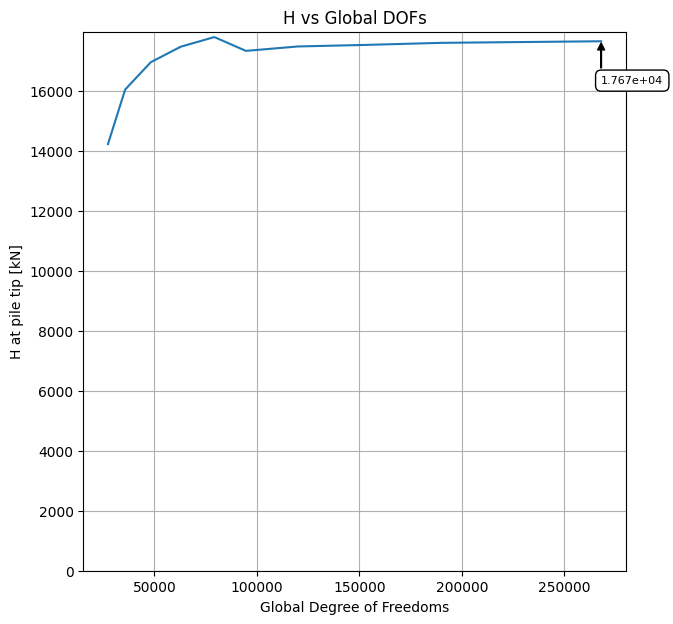

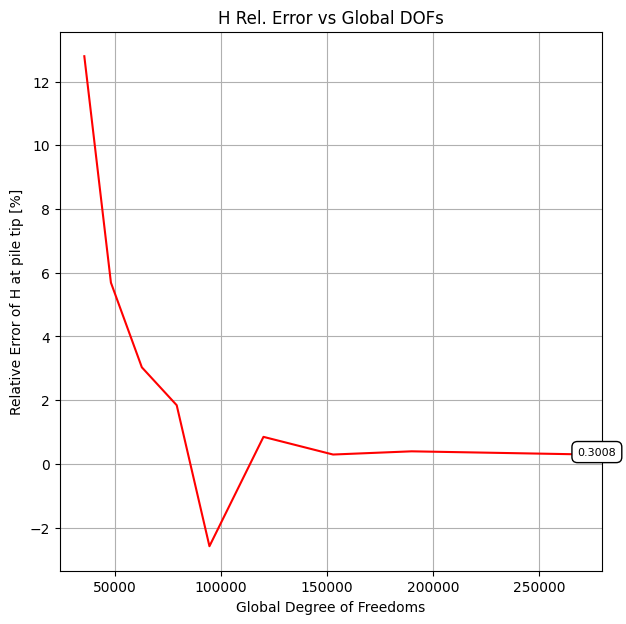

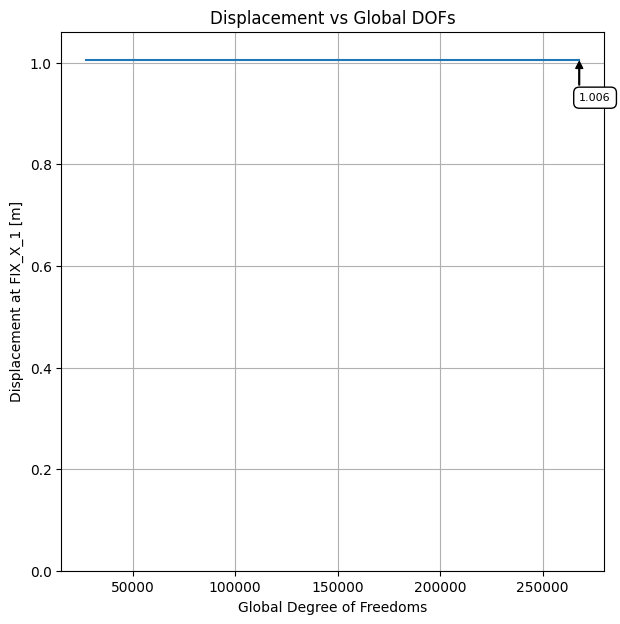

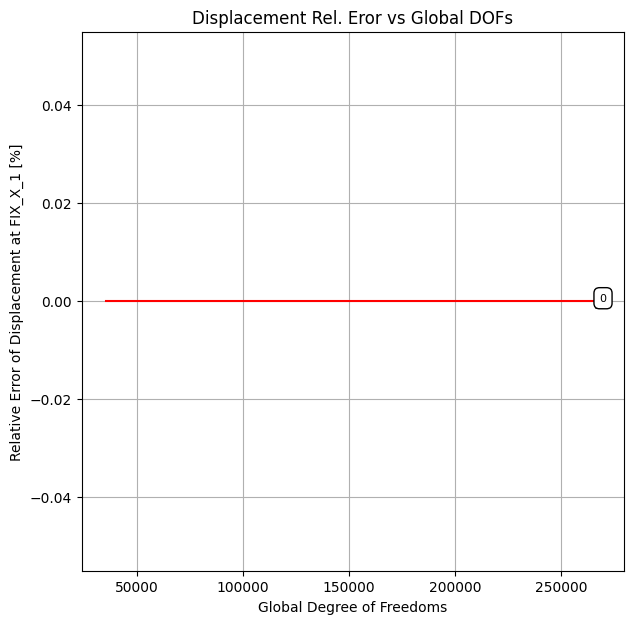

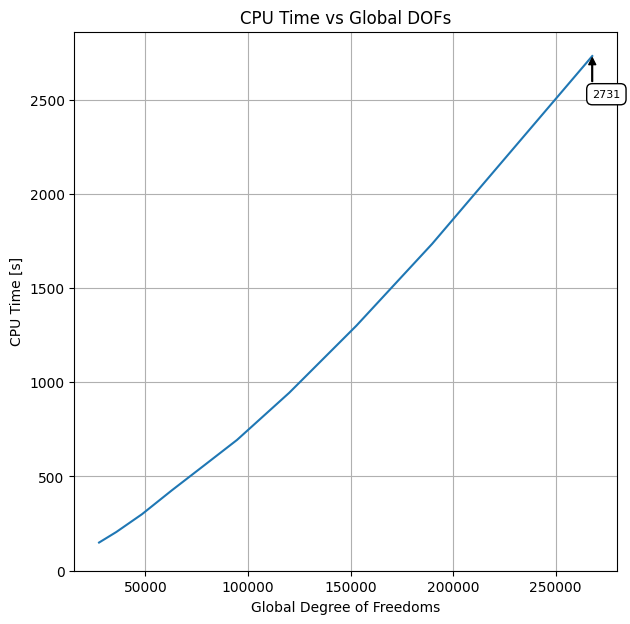

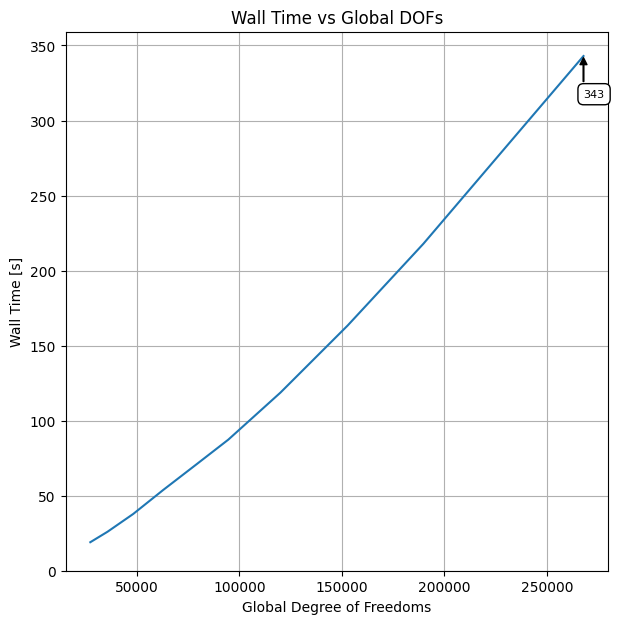

In [20]:
from pathlib import Path
import os
import json
import sys

import pydantic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('/mofem_install/jupyter/thomas/mfront_example_test/src')

import custom_models as cm
import plotting

bulk_sim_id = "Friday_AFK_le"
bulk_dir = Path(f"/mofem_install/jupyter/thomas/mfront_example_test/simulations/bulk_{bulk_sim_id}")
bulk_log = bulk_dir / "pile_bulk.log"

if os.path.exists(bulk_log):
    with open(bulk_log, 'r') as f:
        logs = json.load(f)
else:
    raise FileNotFoundError(f"The bulk log with the id '{bulk_sim_id}'is not found. Possibly because this bulk analysis was not performed yet?")

bulk_graph_dir = bulk_dir / "graphs"
bulk_graph_dir.mkdir(parents=True, exist_ok=True)
bulk_csv = bulk_dir / "pile_bulk.csv"


df = {
    "DOFs": [],
    "final_disp": [],
    "final_disp_relative_error": [],
    "H": [],
    "H_relative_error": [],
    "compute_cpu_time": [],
    "compute_wall_time": [],
    "compute_cpu_time_relative_error": [],
    "compute_wall_time_relative_error": [],
}

previous_values = {
    "final_disp": None,
    "H": None,
    "compute_cpu_time": None,
    "compute_wall_time": None,
}
point = cm.Point(x=-1,y=0,z=0)
for i, log in reversed(list(logs.items())):
    params = cm.BulkAnalysisProps.parse_raw(log)
    csv_files = [f for f in os.listdir(point.point_dir(params)) if f.startswith("point_data_") and f.endswith(".csv")]
    max_sig_eq = 1e20
    # for csv_file in csv_files:
    #     pid = int(csv_file.split('_')[2].split('.')[0])
    #     csv = pd.read_csv(point.point_dir(params) / csv_file)
    #     if f"final_stress_{pid}" not in list(df.keys()):
    #         df[f"final_stress_{pid}"] = []
    #         df[f"final_strain_{pid}"] = []
    #     else:
    #         df[f"final_stress_{pid}"].append(csv["STRESS_magnitude"].iloc[-1])
    #         df[f"final_strain_{pid}"].append(csv["STRAIN_magnitude"].iloc[-1])
            
    # data_poi_mudline=pd.read_csv(cm.Point(x=-1,y=0,z=0).point_dir(params) / )
    data_tot_force=pd.read_csv(params.total_force_log_file,sep='\s+',header=None)
    data_force=pd.read_csv(params.FIX_X_1_force_log_file,sep='\s+',header=None)
    data_dofs=pd.read_csv(params.DOFs_log_file,sep='\s+',header=None)
    
    # Function to extract time from a line in the log file
    def extract_time(pattern, log_file):
        result = subprocess.run(
            f"grep '^{pattern}' {log_file} | awk '{{print $2}}'",
            shell=True, text=True, capture_output=True
        )
        time_str = result.stdout.strip()
        if not time_str:
            raise ValueError(f"Failed to find '{pattern}' in the log file.")
        
        # Convert 'XmY.Zs' format to seconds
        match = re.match(r"(\d+)m([\d.]+)s", time_str)
        if match:
            minutes = int(match.group(1))
            seconds = float(match.group(2))
            return minutes * 60 + seconds
        else:
            raise ValueError(f"Unexpected time format: '{time_str}'")

    # Extract times
    real_time = extract_time("real", params.full_fe_log)
    user_time = extract_time("user", params.full_fe_log)
    sys_time = extract_time("sys", params.full_fe_log)

    # Calculate total CPU time and wall-clock time
    user_sys_time = user_time + sys_time
    total_cpu_time = user_sys_time
    wall_clock_time = real_time
    
    
    pile_tip_lateral_load = - data_force[4].values * 2 * (10 ** 6) / 1000
    ground_level_passive_lateral_final_disp = data_poi_mudline["DISPLACEMENT_magnitude"].iloc[-1]
    DOF = data_dofs[15][0]
    
    current_values = {
        "final_disp": ground_level_passive_lateral_final_disp,
        "H": pile_tip_lateral_load[-1],
        "compute_cpu_time": total_cpu_time,
        "compute_wall_time": wall_clock_time,
    }
    
    for key in current_values:
        if previous_values[key] is not None:
            relative_error = (current_values[key] - previous_values[key]) / abs(previous_values[key]) * 100
            df[f"{key}_relative_error"].append(relative_error)
        else:
            df[f"{key}_relative_error"].append(None)  # No previous value to compare with
        previous_values[key] = current_values[key]
    
    
    df["DOFs"].append(DOF)
    df["H"].append(pile_tip_lateral_load[-1])
    df["final_disp"].append(ground_level_passive_lateral_final_disp)
    df["compute_cpu_time"].append(total_cpu_time)
    df["compute_wall_time"].append(wall_clock_time)

for i, j in df.items():
    print(i, len(j))

df = pd.DataFrame(df)

df.to_csv(bulk_csv)

plotting.plot_x_ys(df["DOFs"], [df["H"]], labels=[""], x_label='Global Degree of Freedoms', y_label='H at pile tip [kN]', title='H vs Global DOFs', save_as = f"{bulk_graph_dir}/001_H_DOFs.png", show=True, enforce_pass_through_zero=True)
plotting.plot_x_ys(df["DOFs"], [df["H_relative_error"]], labels=[""], colors=["r"], x_label='Global Degree of Freedoms', y_label='Relative Error of H at pile tip [%]', title='H Rel. Error vs Global DOFs', save_as = f"{bulk_graph_dir}/001_1_H_DOFs_rel_error.png", show=True, enforce_pass_through_zero=False)

# for column in df.columns:
#     if "final_stress" in column:
#         plotting.plot_x_ys(df["DOFs"], [df[column]], labels=[""], x_label='Global Degree of Freedoms', y_label='Stress at mudline [MPa]', title=f'{column} vs Global DOFs', save_as = f"{bulk_graph_dir}/002_{column}_DOFs.png", show=True, enforce_pass_through_zero=True)
#         plotting.plot_x_ys(df["DOFs"], [df[f"{column}_relative_error"]], labels=[""], colors=["r"], x_label='Global Degree of Freedoms', y_label='Relative Error of Stress at mudline [MPa]', title=f'{column} Rel. Error vs Global DOFs', save_as = f"{bulk_graph_dir}/002_1_{column}_DOFs_rel_error.png", show=True, enforce_pass_through_zero=False)
#     elif "final_strain" in column:
#         plotting.plot_x_ys(df["DOFs"], [df[column]], labels=[""], x_label='Global Degree of Freedoms', y_label='Strain at mudline [-]', title=f'{column} vs Global DOFs', save_as = f"{bulk_graph_dir}/003_{column}_DOFs.png", show=True, enforce_pass_through_zero=True)
#         plotting.plot_x_ys(df["DOFs"], [df[f"{column}_relative_error"]], labels=[""], colors=["r"], x_label='Global Degree of Freedoms', y_label='Relative Error of Strain at mudline [MPa]', title=f'{column} Rel. Error vs Global DOFs', save_as = f"{bulk_graph_dir}/003_1_Strain_DOFs_rel_error.png", show=True, enforce_pass_through_zero=False)


plotting.plot_x_ys(df["DOFs"], [df["final_disp"]], labels=["Displacement at Pile Tip [m]"], colors=None,x_label='Global Degree of Freedoms', y_label='Displacement at FIX_X_1 [m]', title='Displacement vs Global DOFs', save_as = f"{bulk_graph_dir}/004_Displacement_DOFs.png", show=True, enforce_pass_through_zero=True)
plotting.plot_x_ys(df["DOFs"], [df["final_disp_relative_error"]], labels=["Relative error [%]"], colors=["r"],x_label='Global Degree of Freedoms', y_label='Relative Error of Displacement at FIX_X_1 [%]', title='Displacement Rel. Eror vs Global DOFs', save_as = f"{bulk_graph_dir}/004_1_Displacement_DOFs_rel_error.png", show=True, enforce_pass_through_zero=False,annotate_last_datapoint=True)

plotting.plot_x_ys(df["DOFs"], [df["compute_cpu_time"]], labels=[""], x_label='Global Degree of Freedoms', y_label='CPU Time [s]', title='CPU Time vs Global DOFs', save_as = f"{bulk_graph_dir}/005_CPUTime_DOFs.png", show=True, enforce_pass_through_zero=True)
plotting.plot_x_ys(df["DOFs"], [df["compute_wall_time"]], labels=[""], x_label='Global Degree of Freedoms', y_label='Wall Time [s]', title='Wall Time vs Global DOFs', save_as = f"{bulk_graph_dir}/006_WallTime_DOFs.png", show=True, enforce_pass_through_zero=True)